# Test detrending

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import pathlib
import os
import src.utils
import scipy.stats

## set plotting specs
sns.set(rc={"axes.facecolor": "white", "axes.grid": False})

## get filepaths
DATA_FP = pathlib.Path(os.environ["DATA_FP"])

## Load Sen's pre-computed indices as validation

In [2]:
## open data
oras_load_fp = pathlib.Path(DATA_FP, "XRO_indices_oras5.nc")
anom_sen = xr.open_dataset(oras_load_fp)

## rename variables for consistency and trim so time periods covered are the same
anom_sen = anom_sen[["Nino34", "WWV"]].rename({"Nino34": "n34", "WWV": "h"})
anom_sen = anom_sen.sel(time=slice("1979", "2018"))

## Load data and detrend

In [3]:
## specify filepaths
oras_sst_fp = pathlib.Path(DATA_FP, "oras5", "sst")
oras_ssh_fp = pathlib.Path(DATA_FP, "oras5", "ssh")

## load data
data = src.utils.load_oras_spatial(oras_sst_fp, oras_ssh_fp)

## estimate forced signal by removing 2nd-order polynomial from each calendar month
detrend_fn = lambda x: src.utils.detrend_dim(x, dim="time", deg=2)
anom = data.groupby("time.month").map(detrend_fn)
forced = data - anom

## compute indices
anom["n34"] = src.utils.get_nino34(anom["sst"])
anom["h"] = src.utils.get_RO_h(anom["ssh"])

## make times equivalent
anom["time"] = anom_sen["time"]

## normalize "h" for comparison (comparing SSH vs. thermocline depth)
anom["h_norm"] = anom["h"] / anom["h"].std()
anom_sen["h_norm"] = anom_sen["h"] / anom_sen["h"].std()

## Plot comparison

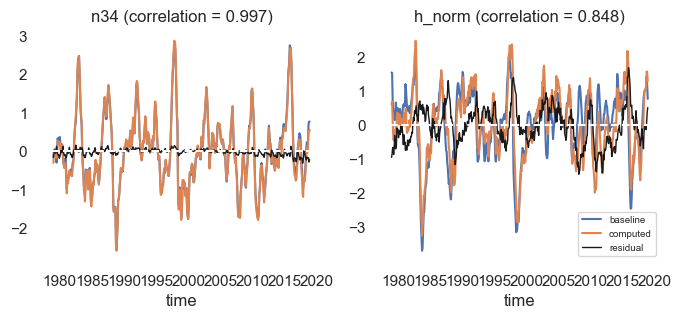

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

for ax, n in zip(axs, ["n34", "h_norm"]):
    ax.plot(anom_sen.time, anom_sen[n], label="baseline")
    ax.plot(anom.time, anom[n], label="computed")
    ax.plot(anom.time, anom[n] - anom_sen[n], c="k", lw=1, label="residual")
    ax.axhline(0, ls="--", c="w")

    ## compute correlation
    r = scipy.stats.pearsonr(anom[n], anom_sen[n])[0]

    ## label
    ax.set_title(f"{n} (correlation = {r:.3f})")
    ax.set_xlabel("time")

## add legend
ax.legend(prop=dict(size=7))

plt.show()